# Statica

In [1]:
import numpy as np
from numpy import linalg
from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp

from qiskit.quantum_info import Kraus, SuperOp
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.models import BackendProperties
from qiskit.providers.aer import noise

from qiskit.tools.monitor import job_monitor
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit import IBMQ
from qiskit.opflow import Z, I, X
from qiskit.circuit.library import EfficientSU2

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

from qiskit import IBMQ, Aer
from qiskit_aer.noise import NoiseModel

from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

import matplotlib.pyplot as plt

## Calcolo ground state classico

In [2]:
def H_ising(num_qubits,J,b):
    m=num_qubits-1
    n=num_qubits-2
    G=b*((I^m)^X)
    H=0
    hamiltonian1=H
    hamiltonian2=G
    
    for i in range(n+1):
        H =(I^i)^Z^Z^(I^(n-i))
        G=(I^i)^X^(I^(m-i))
        hamiltonian1=hamiltonian1+J*H
        hamiltonian2=hamiltonian2+b*G
    
    hamiltonian=hamiltonian1+hamiltonian2
    return hamiltonian

In [5]:
nShots = 8192
J = -1
b = np.linspace(0,4,10)

num_qubits=4
E_l = []
P_l = []
energy_levels = []

for k in range(len(b)):
    hamiltonian=Operator(H_ising(num_qubits,J,b[k]))
    
    # Extract eig
    E_l,P_l = linalg.eig(hamiltonian.data)

    Es = np.sort(E_l)

    energy_levels.append(np.real(Es))

## Calcolo ground state quantistico 

In [6]:
provider = IBMQ.enable_account('77dda7985ecda9fa85b6dcc27eea16f88f9d96e9732aea4d184e9270ec00a8f76ec5e14f289d0a7c28ab9b755d5e205e42781d238358bc64675bcc8abbda9c1f')
#provider   = IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [7]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [8]:
#optimizer = COBYLA(maxiter=50, tol=0.001, rhobeg=1.0)
optimizer = SPSA(maxiter=50)
###############################

HW = 'ibmq_manila'
BK = "noiseless" # "noiseless", "hardware"

if BK == "noiseless":
    
    backend = Aer.get_backend("qasm_simulator")
    quantum_instance = QuantumInstance(backend,
                                       shots=nShots)
    
if BK == "noisy":
    
    device = provider.get_backend(HW)
    coupling_map = device.configuration().coupling_map
    prop = device.properties()
    
    noise_model = NoiseModel.from_backend(device)
    
    basis_gates = noise_model.basis_gates

    backend = Aer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend,
                                       shots=nShots,
                                       basis_gates=basis_gates,
                                       noise_model=noise_model,
                                       coupling_map=coupling_map)
    
if BK == "hardware":
    
    device = provider.get_backend(HW)
    prop = device.properties()
    
    quantum_instance = QuantumInstance(device,
                                       shots=nShots)

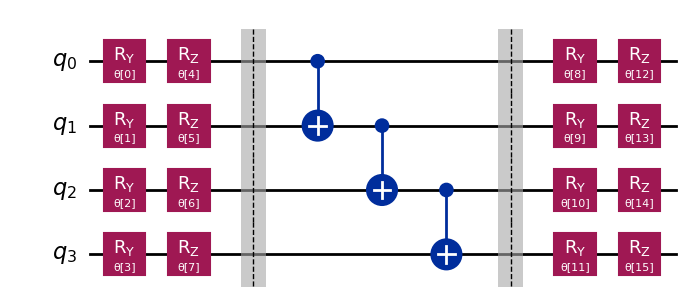

In [9]:
# the rotation gates are chosen randomly, so we set a seed for reproducibility

np.random.seed(10)  # seed for reproducibility

ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 

initial_point = np.random.random(ansatz.num_parameters)

ansatz.decompose().draw('mpl', style='iqx')

In [10]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [11]:
vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

In [13]:
energy = []

y_error=[]

for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error.append(np.mean(intermediate_info['stddev']))
    energy.append(result.eigenvalue)


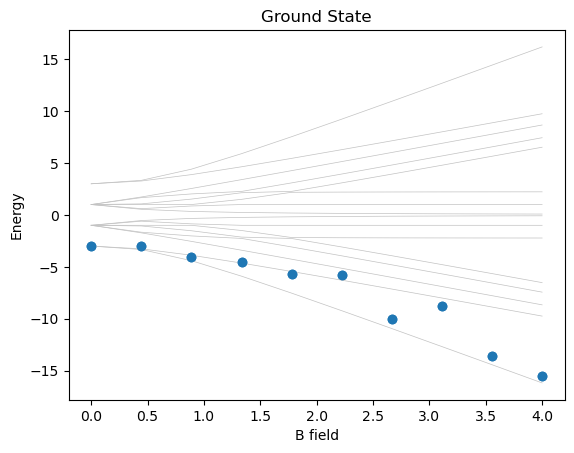

In [18]:
##VERY ROUGH RESULTS WITHOUT OPTIMIZATION

fig, ax = plt.subplots()
#plt.xticks(b)

ax.scatter(b, energy)

#ax.set_ylim((-14.5, -2.5))

#Error

plt.errorbar(b, energy, yerr=y_error, fmt="o")

ax.plot(b, energy_levels, color="#c2c2c2", linewidth=.5)

ax.set(xlabel='B field', ylabel='Energy', title='Ground State')

#ax.grid()
plt.show()


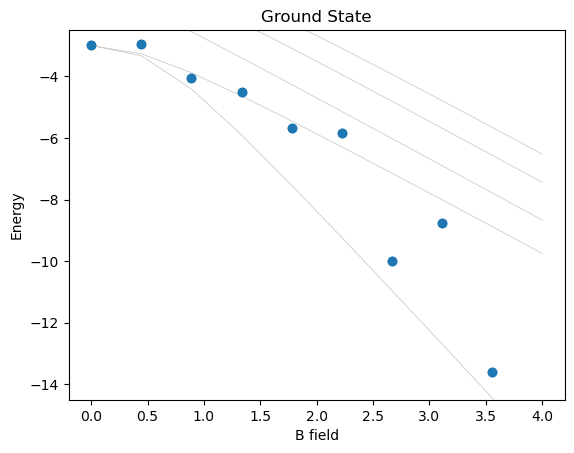

In [19]:
##VERY ROUGH RESULTS WITHOUT OPTIMIZATION

fig, ax = plt.subplots()
#plt.xticks(b)

ax.scatter(b, energy)

ax.set_ylim((-14.5, -2.5))

#Error

plt.errorbar(b, energy, yerr=y_error, fmt="o")

ax.plot(b, energy_levels, color="#c2c2c2", linewidth=.5)

ax.set(xlabel='B field', ylabel='Energy', title='Ground State')

#ax.grid()
plt.show()
